In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget http://apachemirror.wuchna.com/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark


--2019-11-02 10:48:02--  http://apachemirror.wuchna.com/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
Resolving apachemirror.wuchna.com (apachemirror.wuchna.com)... 104.26.2.179, 104.26.3.179, 2606:4700:20::681a:3b3, ...
Connecting to apachemirror.wuchna.com (apachemirror.wuchna.com)|104.26.2.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230091034 (219M) [application/x-gzip]
Saving to: ‘spark-2.4.4-bin-hadoop2.7.tgz’

spark-2.4.4-bin-had 100%[===================>] 219.43M  9.46MB/s    in 21s     

2019-11-02 10:48:23 (10.7 MB/s) - ‘spark-2.4.4-bin-hadoop2.7.tgz’ saved [230091034/230091034]



In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
lines = spark.read.text('/content/pg100.txt').rdd.map(lambda r: r[0])
counts = lines.flatMap(lambda x: x.split(' ')).map(lambda x: (x, 1)).reduceByKey(lambda x,y : x+y)
counts.saveAsTextFile('output')
output = counts.collect()

for (word, count) in output:
    print("%s: %i" % (word, count))


In [0]:
lines = spark.read.text('/content/pg100.txt').rdd.map(lambda r: r[0])
bigrams = lines.map(lambda s : s.split(' ')).flatMap(lambda s : [((s[i],s[i+1]),1) for i in range(0, len(s)-1)])
bigrams.collect()

counts = bigrams.reduceByKey(lambda x, y : x+y)
counts.saveAsTextFile('output_bi-grams')
counts.collect()


In [0]:
import sys
import numpy as np
import pandas as pd

def parseVector(line):
    return np.array([float(x) for x in line.split(' ')])

# Manhattan nearest cluster 
def closestPoint_man(p, centers):
    bestIndex = 0
    closest = float('+inf')
    for i in range(len(centers)):
        tempDist = np.sum(abs(p-centers[i]))
        if tempDist < closest:
            closest = tempDist
            bestIndex = i

    return bestIndex

# Euclidean nearest cluster
def closestPoint_euc(p, centers):
    bestIndex = 0
    closest = float('+inf')
    for i in range(len(centers)):
        tempDist = np.sum((p-centers[i])**2)
        tempDist = np.sqrt(tempDist)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i

    return bestIndex

In [0]:
# Euclidean distance on Near.txt
lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_near = pd.read_csv('/content/near.txt',sep = ' ').values

tempDist = 1.0
L = []
x = 0
while tempDist > convergeDist:
    closest = data.map(lambda p: (closestPoint_euc(p, kPoints_near), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sqrt(np.sum((kPoints_near[iK] - p)**2)) for (iK,p) in newPoints)
    L.append([x,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_near[iK] = p

print('Final centers: '+str(kPoints_near))


Final centers: [[2.98800000e-01 1.43000000e-01 2.81400000e-01 8.88000000e-02
  7.20000000e-02 1.04400000e-01 1.92000000e-02 1.37200000e-01
  2.23400000e-01 3.86000000e-01 1.42200000e-01 6.15000000e-01
  3.28600000e-01 6.36800000e-01 2.50000000e-02 1.51600000e-01
  2.64600000e-01 1.24800000e-01 1.83640000e+00 4.48000000e-02
  8.40200000e-01 3.14000000e-02 4.42000000e-01 2.80800000e-01
  1.17400000e-01 8.56000000e-02 5.40000000e-03 1.40000000e-03
  2.00000000e-03 3.60000000e-03 0.00000000e+00 0.00000000e+00
  2.92600000e-01 0.00000000e+00 0.00000000e+00 3.16000000e-02
  1.91200000e-01 2.00000000e-03 6.20000000e-03 3.48000000e-02
  2.32000000e-02 7.20000000e-03 4.20000000e-03 1.62000000e-02
  4.12000000e-02 5.34000000e-02 9.20000000e-03 4.72000000e-02
  3.34400000e-02 1.16400000e-01 1.07400000e-02 2.41660000e-01
  3.20900000e-01 8.51600000e-02 6.55382000e+00 2.08280000e+02
  3.32042000e+03 7.40000000e-01]
 [9.60000000e-02 8.00000000e-03 1.96000000e-01 8.00000000e-03
  9.20000000e-02 1.180

In [0]:
# Manhattan distance on Near.txt

lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_near = pd.read_csv('/content/near.txt',sep = ' ').values

tempDist = 1.0
L = []
x = 0
while tempDist > convergeDist:
    closest = data.map(lambda p: (closestPoint_man(p, kPoints_near), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum(abs(kPoints_near[iK] - p)) for (iK,p) in newPoints)
    L.append([x,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_near[iK] = p

print('Final centers: '+str(kPoints_near))


Final centers: [[3.04897959e-01 1.45918367e-01 2.77755102e-01 9.06122449e-02
  7.34693878e-02 1.06530612e-01 1.95918367e-02 1.36938776e-01
  2.27959184e-01 3.93877551e-01 1.45102041e-01 6.24489796e-01
  3.35306122e-01 6.49795918e-01 2.55102041e-02 1.54693878e-01
  2.70000000e-01 1.17959184e-01 1.85489796e+00 4.57142857e-02
  8.57346939e-01 3.20408163e-02 4.41632653e-01 2.86530612e-01
  1.19795918e-01 8.73469388e-02 5.51020408e-03 1.42857143e-03
  2.04081633e-03 3.67346939e-03 0.00000000e+00 0.00000000e+00
  2.98571429e-01 0.00000000e+00 0.00000000e+00 2.91836735e-02
  1.95102041e-01 2.04081633e-03 6.32653061e-03 1.65306122e-02
  2.36734694e-02 7.34693878e-03 4.28571429e-03 1.65306122e-02
  4.20408163e-02 5.44897959e-02 9.38775510e-03 4.81632653e-02
  3.26734694e-02 1.17326531e-01 1.09591837e-02 2.44653061e-01
  3.26979592e-01 8.68979592e-02 5.40695918e+00 1.81816327e+02
  3.33183673e+03 7.34693878e-01]
 [9.60000000e-02 8.00000000e-03 1.96000000e-01 8.00000000e-03
  9.20000000e-02 1.180

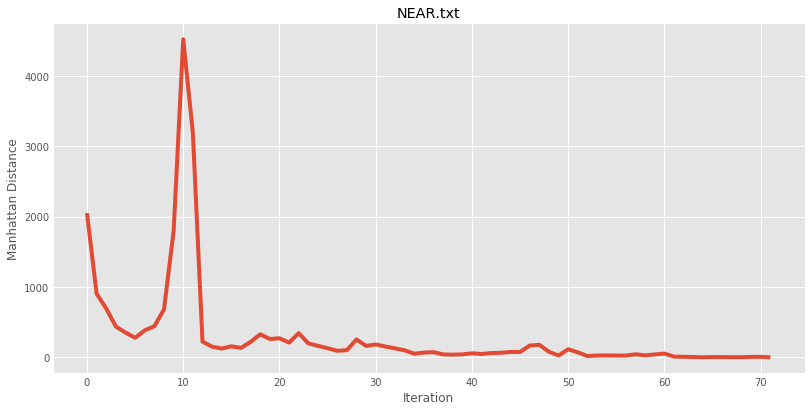

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Manhattan Distance")
plt.title("NEAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()

In [0]:
# Euclidean distance on Far.txt

lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_far = pd.read_csv('/content/far.txt',sep = ' ').values
tempDist = 1.0
L = []
x = 0
while tempDist > convergeDist:
    closest = data.map(lambda p: (closestPoint_euc(p, kPoints_far), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sqrt(np.sum((kPoints_far[iK] - p)**2)) for (iK,p) in newPoints)
    L.append([x,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_far[iK] = p

print('Final centers: '+str(kPoints_far))


Final centers: [[1.90000000e-01 0.00000000e+00 3.80000000e-01 0.00000000e+00
  0.00000000e+00 1.90000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.90000000e-01 1.90000000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e-01
  0.00000000e+00 1.90000000e-01 1.14000000e+00 0.00000000e+00
  3.80000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e-02 1.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e-03 2.38300000e+00 2.10000000e+01
  1.58410000e+04 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e-02
  0.00000000e+00 0.000

In [0]:
# Manhattan Distance on Far.txt

lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_far = pd.read_csv('/content/far.txt',sep = ' ').values
tempDist = 1.0
L = []
x = 0
while tempDist > convergeDist:
    closest = data.map(lambda p: (closestPoint_man(p, kPoints_far), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum(abs(kPoints_far[iK] - p)) for (iK,p) in newPoints)
    L.append([x,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_far[iK] = p

print('Final centers: '+str(kPoints_far))


Final centers: [[1.90000000e-01 0.00000000e+00 3.80000000e-01 0.00000000e+00
  0.00000000e+00 1.90000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.90000000e-01 1.90000000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e-01
  0.00000000e+00 1.90000000e-01 1.14000000e+00 0.00000000e+00
  3.80000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e-02 1.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e-03 2.38300000e+00 2.10000000e+01
  1.58410000e+04 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e-02
  0.00000000e+00 0.000

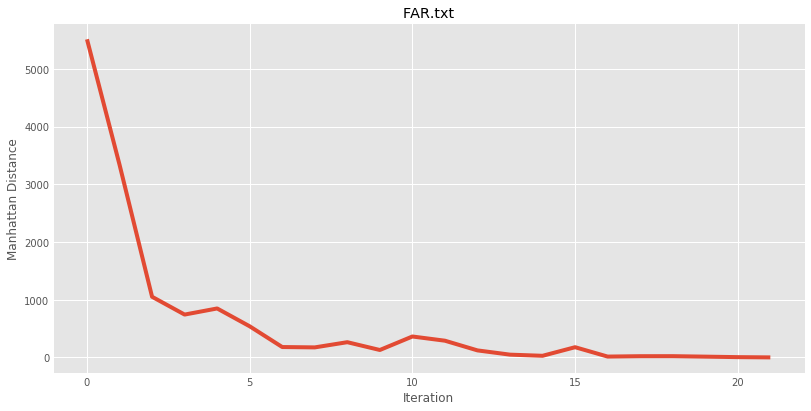

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Manhattan Distance")
plt.title("FAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()

Final centers: [[1.24883721e-01 1.21395349e-01 3.00387597e-01 2.22403101e-01
  2.81782946e-01 1.05658915e-01 8.97674419e-02 1.03178295e-01
  3.89922481e-01 3.95658915e-01 9.51162791e-02 4.98604651e-01
  1.22713178e-01 9.71317829e-02 9.90697674e-02 2.47441860e-01
  9.82170543e-02 3.05193798e-01 1.50798450e+00 2.30000000e-01
  9.36666667e-01 9.29302326e-01 1.49767442e-01 1.66899225e-01
  3.22635659e-01 1.58294574e-01 2.35658915e-02 1.48062016e-02
  4.57364341e-03 1.57364341e-02 2.33333333e-02 6.97674419e-04
  8.05426357e-02 1.70542636e-03 1.15658915e-01 2.68992248e-02
  1.51937984e-01 2.01550388e-03 2.03100775e-02 2.93023256e-02
  1.10077519e-02 3.33333333e-02 1.01550388e-02 1.64341085e-02
  3.49612403e-02 5.44186047e-02 1.24031008e-02 2.83720930e-02
  4.66589147e-02 1.34255814e-01 4.18294574e-02 2.83651163e-01
  1.66410853e-01 1.07178295e-01 5.91619380e+00 1.05829457e+02
  1.22753488e+03 6.43410853e-01]
 [2.85961538e-01 1.31730769e-01 2.72307692e-01 8.36538462e-02
  7.42307692e-02 1.078

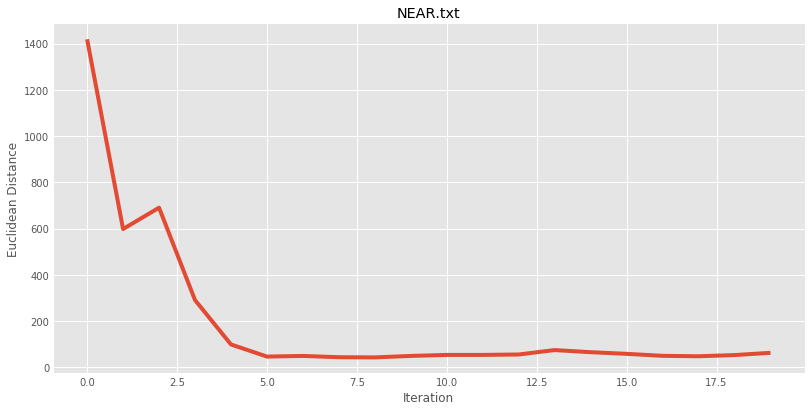

Final centers: [[1.90000000e-01 0.00000000e+00 3.80000000e-01 0.00000000e+00
  0.00000000e+00 1.90000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.90000000e-01 1.90000000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e-01
  0.00000000e+00 1.90000000e-01 1.14000000e+00 0.00000000e+00
  3.80000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e-02 1.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e-03 2.38300000e+00 2.10000000e+01
  1.58410000e+04 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e-02
  0.00000000e+00 0.000

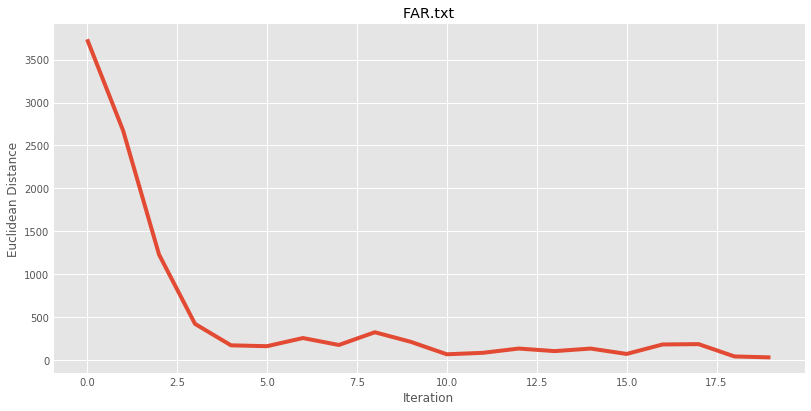

In [0]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

def parseVector(line):
    return np.array([float(x) for x in line.split(' ')])

def closestPoint_euc(p, centers):
    bestIndex = 0
    closest = float('+inf')
    for i in range(len(centers)):
        tempDist = np.sum((p-centers[i])**2)
        tempDist = np.sqrt(tempDist)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i

    return bestIndex


lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_near = pd.read_csv('/content/near.txt',sep = ' ').values
max_iter = 20
tempDist = 1.0
L = []
x = 0
for i in range(max_iter):
    closest = data.map(lambda p: (closestPoint_euc(p, kPoints_near), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sqrt(np.sum((kPoints_near[iK] - p)**2)) for (iK,p) in newPoints)
    L.append([i,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_near[iK] = p

print('Final centers: '+str(kPoints_near))



style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance")
plt.title("NEAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()


kPoints_far = pd.read_csv('/content/far.txt',sep = ' ').values
tempDist = 1.0
L = []
x = 0
for i in range(max_iter):
    closest = data.map(lambda p: (closestPoint_euc(p, kPoints_far), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sqrt(np.sum((kPoints_far[iK] - p)**2)) for (iK,p) in newPoints)
    L.append([i,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_far[iK] = p

print('Final centers: '+str(kPoints_far))

style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance")
plt.title("FAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()





Final centers: [[3.12307692e-01 1.75230769e-01 3.08000000e-01 6.83076923e-02
  1.08769231e-01 9.52307692e-02 2.09230769e-02 1.40307692e-01
  2.71538462e-01 4.40615385e-01 1.63076923e-01 6.09384615e-01
  3.39538462e-01 6.56307692e-01 5.66153846e-02 1.54153846e-01
  2.79076923e-01 1.25076923e-01 1.98061538e+00 4.10769231e-02
  9.00307692e-01 2.41538462e-02 4.47076923e-01 3.13692308e-01
  1.08461538e-01 8.46153846e-02 4.15384615e-03 1.38461538e-03
  1.84615385e-03 2.76923077e-03 0.00000000e+00 0.00000000e+00
  2.84923077e-01 0.00000000e+00 9.23076923e-04 3.13846154e-02
  1.91230769e-01 2.30769231e-03 6.15384615e-03 2.80000000e-02
  2.03076923e-02 6.46153846e-03 6.61538462e-03 1.36923077e-02
  5.12307692e-02 5.15384615e-02 7.38461538e-03 4.52307692e-02
  3.16461538e-02 1.16092308e-01 9.06153846e-03 2.61415385e-01
  3.78569231e-01 8.38461538e-02 6.66829231e+00 2.59984615e+02
  3.11467692e+03 7.69230769e-01]
 [9.60000000e-02 8.00000000e-03 1.96000000e-01 8.00000000e-03
  9.20000000e-02 1.180

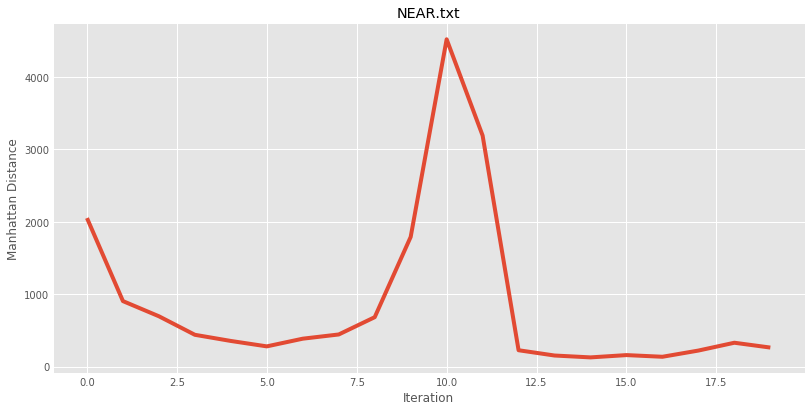

Final centers: [[1.90000000e-01 0.00000000e+00 3.80000000e-01 0.00000000e+00
  0.00000000e+00 1.90000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.90000000e-01 1.90000000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e-01
  0.00000000e+00 1.90000000e-01 1.14000000e+00 0.00000000e+00
  3.80000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e-02 1.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.00000000e-03 2.38300000e+00 2.10000000e+01
  1.58410000e+04 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e-02
  0.00000000e+00 0.000

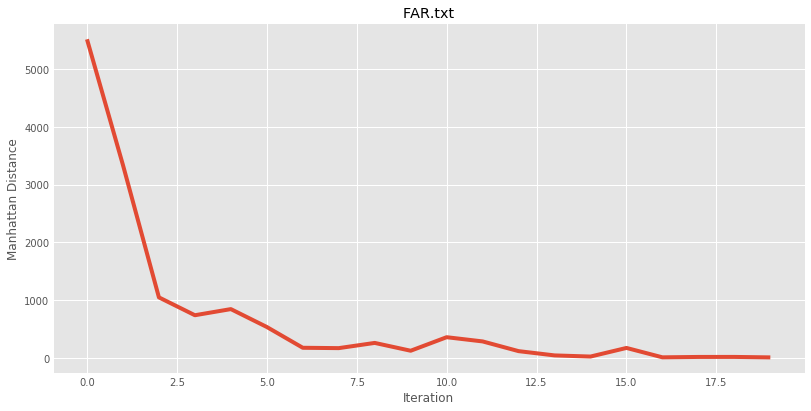

In [0]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

def parseVector(line):
    return np.array([float(x) for x in line.split(' ')])

def closestPoint_man(p, centers):
    bestIndex = 0
    closest = float('+inf')
    for i in range(len(centers)):
        tempDist = np.sum(abs(p-centers[i]))
        if tempDist < closest:
            closest = tempDist
            bestIndex = i

    return bestIndex


lines = spark.read.text('/content/data.txt').rdd.map(lambda r: r[0])
data = lines.map(parseVector).cache()

convergeDist = 0.001
K = 10
kPoints_near = pd.read_csv('/content/near.txt',sep = ' ').values
max_iter = 20
tempDist = 1.0
L = []
x = 0
for i in range(max_iter):
    closest = data.map(lambda p: (closestPoint_man(p, kPoints_near), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum(abs(kPoints_near[iK] - p)) for (iK,p) in newPoints)
    L.append([i,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_near[iK] = p

print('Final centers: '+str(kPoints_near))

style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Manhattan Distance")
plt.title("NEAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()


kPoints_far = pd.read_csv('/content/far.txt',sep = ' ').values
tempDist = 1.0
L = []
x = 0
for i in range(max_iter):
    closest = data.map(lambda p: (closestPoint_man(p, kPoints_far), (p,1)))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum(abs(kPoints_far[iK] - p)) for (iK,p) in newPoints)
    L.append([i,tempDist])
    x += 1
    for (iK, p) in newPoints:
        kPoints_far[iK] = p

print('Final centers: '+str(kPoints_far))


style.use('ggplot')
X = np.array(L)
plt.figure(figsize=(12,6))
plt.xlabel("Iteration")
plt.ylabel("Manhattan Distance")
plt.title("FAR.txt")
plt.plot(X[:,0],X[:,1])
plt.show()


In [0]:
spark.stop()